# Introducing the Keras Functional API

**Learning Objectives**
  - Understand embeddings and how to create them with the feature column API
  - Understand Deep and Wide models and when to use them
  - Understand the Keras functional API and how to build a deep and wide model with it

## Introduction

In the last notebook, we learned about the Keras Sequential API. The [Keras Functional API](https://www.tensorflow.org/guide/keras#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).

In this notebook we'll use what we learned about feature columns to build a Wide & Deep model. Recall, that the idea behind Wide & Deep models is to join the two methods of learning through memorization and generalization by making a wide linear model and a deep learning model to accommodate both. You can have a look at the original research paper here: [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

<img src='assets/wide_deep.png' width='80%'>
<sup>(image: https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)</sup>

The Wide part of the model is associated with the memory element. In this case, we train a linear model with a wide set of crossed features and learn the correlation of this related data with the assigned label. The Deep part of the model is associated with the generalization element where we use embedding vectors for features. The best embeddings are then learned through the training process. While both of these methods can work well alone, Wide & Deep models excel by combining these techniques together. 

In [1]:
#  Ensure that we have the latest version of Tensorflow installed.
!pip3 freeze | grep tf-nightly-2.0-preview || pip3 install tf-nightly-2.0-preview

tf-nightly-2.0-preview==2.0.0.dev20190925


Start by importing the necessary libraries for this lab.

In [2]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow import feature_column as fc

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, DenseFeatures, concatenate)
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

2.0.0-dev20190925


In [3]:
%matplotlib inline

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [4]:
!ls -l ../data/*.csv

-rw-r--r--  1 dherin  primarygroup  123590 Sep 25 14:39 ../data/taxi-test.csv
-rw-r--r--  1 dherin  primarygroup  579055 Sep 25 14:39 ../data/taxi-train.csv
-rw-r--r--  1 dherin  primarygroup  123114 Sep 25 14:39 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](2_dataset_api.ipynb). For this lab we will also include some additional engineered features in our model. In particular, we will compute the difference in latitude and longitude, as well as the Euclidean distance between the pick-up and drop-off locations. We can accomplish this by adding these new features to the features dictionary with the function `add_engineered_features` below. 

Note that we include a call to this function when collecting our features dict and labels in the `features_and_labels` function below as well. 

In [5]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
        
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Feature columns for Wide and Deep model

For the Wide columns, we will create feature columns of crossed features. To do this, we'll create a collection of Tensorflow feature columns to pass to the `tf.feature_column.crossed_column` constructor. The Deep columns will consist of numeric columns and the embedding columns we want to create. 

In [6]:
# 1. Bucketize latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

fc_bucketized_plat = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_plon = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_dlat = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_longitude"), boundaries=lonbuckets)
fc_bucketized_dlon = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_latitude"), boundaries=latbuckets)

# 2. Cross features for locations
fc_crossed_dloc = fc.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_ploc = fc.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_pd_pair = fc.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

# 3. Create embedding columns for the crossed columns
fc_pd_pair = fc.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
fc_dloc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
fc_ploc = fc.embedding_column(categorical_column=fc_crossed_ploc, dimension=3)

### Gather list of feature columns

Next we gather the list of wide and deep feature columns we'll pass to our Wide & Deep model in Tensorflow. Recall, wide columns are sparse, have linear relationship with the output while continuous columns are deep, have a complex relationship with the output. We will use our previously bucketized columns to collect crossed feature columns and sparse feature columns for our wide columns, and embedding feature columns and numeric features columns for the deep columns.

In [7]:
wide_columns = [
    # One-hot encoded feature crosses
    fc.indicator_column(fc_crossed_dloc),
    fc.indicator_column(fc_crossed_ploc),
    fc.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding_column to "group" together ...
    fc.embedding_column(fc_crossed_pd_pair, dimension=10),

    # Numeric columns
    fc.numeric_column("pickup_latitude"),
    fc.numeric_column("pickup_longitude"),
    fc.numeric_column("dropoff_longitude"),
    fc.numeric_column("dropoff_latitude")
]

## Build a Wide and Deep model in Keras

To build a wide-and-deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here’s that model architecture looks using the Functional API.

First, we'll create our input columns using [tf.keras.layers.Input](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Input).

In [8]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS
}

Then, we'll define our custom RMSE evaluation metric and build our wide and deep model.

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model(dnn_hidden_units):
    # Create the deep part of model
    deep = DenseFeatures(deep_columns, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 

    # Create the wide part of model
    wide = DenseFeatures(wide_columns, name='wide_inputs')(inputs)

    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined')

    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation=None, name='prediction')(combined)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers, each with 10 neurons, for the deep part of our model. We can also use `plot_model` to see a diagram of the model we've created.

In [10]:
HIDDEN_UNITS = [10,10]

model = build_model(dnn_hidden_units=HIDDEN_UNITS)

tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Next, we'll set up our training variables, create our datasets for training and validation, and train our model.

In [11]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='../data/taxi-train*',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = create_dataset(
    pattern='../data/taxi-valid*',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [12]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True) # start fresh each time

history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(OUTDIR)])

Train for 1 steps, validate for 10 steps
Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 222.2876 - rmse: 14.9093 - mse: 222.2876 - val_loss: 253.2793 - val_rmse: 15.9098 - val_mse: 253.2793
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 235.8223 - rmse: 15.3565 - mse: 235.8223 - val_loss: 251.5203 - val_rmse: 15.8544 - val_mse: 251.5203
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 225.0270 - rmse: 15.0009 - mse: 225.0270 - val_loss: 249.8206 - val_rmse: 15.8007 - val_mse: 249.8206
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 203.7875 - rmse: 14.2754 - mse: 203.7875 - val_loss: 248.1620 - val_rmse: 15.7481 - val_mse: 248.1620
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 210.4895 - rmse: 14.5083 - mse: 210.4895 - val_loss: 246.5190 - val_rmse: 15.6958 - val_mse: 246.5190
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 231.0518 - rmse: 15.2004 - mse: 2

Epoch 49/50
1/1 [==============================] - 4s 4s/step - loss: 92.3562 - rmse: 9.6102 - mse: 92.3562 - val_loss: 136.9994 - val_rmse: 11.6940 - val_mse: 136.9994
Epoch 50/50
1/1 [==============================] - 4s 4s/step - loss: 75.6977 - rmse: 8.7004 - mse: 75.6977 - val_loss: 134.6914 - val_rmse: 11.5948 - val_mse: 134.6913
CPU times: user 8min 14s, sys: 7min 38s, total: 15min 52s
Wall time: 3min 3s


Just as before, we can examine the history to see how the RMSE changes through training on the train set and validation set. 

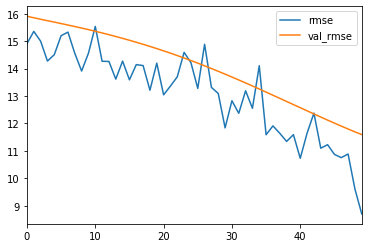

In [13]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

We can also view the training results in Tensorboard. Running the following command will launch TensorBoard on port 6006. This will block the notebook execution, so you'll have to interrupt that cell first before you can run other cells.

In [ ]:
!tensorboard --logdir $OUTDIR --port 6006

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License